In [2]:
import pandas as pd

df1 = pd.read_csv('Bankruptcy_1.csv')
df2 = pd.read_csv('Bankruptcy_2.csv')
df3 = pd.read_csv('Bankruptcy_3.csv')
df4 = pd.read_csv('Bankruptcy_4.csv')
df5 = pd.read_csv('Bankruptcy_5.csv')




C:\Users\Vikrant Mishra\AppData\Local\Temp\ipykernel_9468\1022900032.py:4: DtypeWarning: Columns (1,2,3,6,7,9,10,11,14,18,22,24,25,29,35,36,38,48,51,55,57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('Bankruptcy_2.csv')
C:\Users\Vikrant Mishra\AppData\Local\Temp\ipykernel_9468\1022900032.py:5: DtypeWarning: Columns (15,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('Bankruptcy_3.csv')
C:\Users\Vikrant Mishra\AppData\Local\Temp\ipykernel_9468\1022900032.py:6: DtypeWarning: Columns (1,2,3,6,7,8,10,11,14,15,16,17,18,22,24,25,26,29,34,35,36,38,48,50,51,57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('Bankruptcy_4.csv')


In [3]:
import pandas as pd
import numpy as np

# Combine datasets into one DataFrame (assuming similar structure)
dataframes = [df1, df2, df3, df4, df5]
df = pd.concat(dataframes, ignore_index=True)

# Replace '?' and empty cells with NaN
df.replace('?', np.nan, inplace=True)

# Fill NaN values with 0
df.fillna(0, inplace=True)

# Convert all columns (except the final 'class' column) to numeric types
for col in df.columns[:-1]:  # Assuming the last column is the 'class' label
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Final check for missing or non-numeric values
print(df.isnull().sum())

# Save cleaned dataset
df.to_csv('Cleaned_Bankruptcy_Data.csv', index=False)


id        0
Attr1     0
Attr2     0
Attr3     0
Attr4     0
         ..
Attr61    0
Attr62    0
Attr63    0
Attr64    0
class     0
Length: 66, dtype: int64


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.optimizers import Adam

# Load the cleaned dataset (assumed to be in time-series form)
df = pd.read_csv('Cleaned_Bankruptcy_Data.csv')

# Separate features (X) and target (y)
X = df.iloc[:, :-1].values  # All columns except the last one
y = df.iloc[:, -1].values  # The 'class' column (binary 0/1)

# Step 1: Split data into train and test sets (assuming temporal split is already handled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 2: Stacked Autoencoder (SAE) for Dimensionality Reduction
def build_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    encoded = Dropout(0.2)(encoded)
    
    # Decoder
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    # Autoencoder Model
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)  # This is the encoder part to extract features
    
    # Compile the autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return autoencoder, encoder

# Define the dimensions for SAE
input_dim = X_train.shape[1]  # Number of features
encoding_dim = 32  # You can adjust this for different dimensionality reduction

# Build and train the SAE
autoencoder, encoder = build_autoencoder(input_dim, encoding_dim)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Use the encoder to transform the input data (get reduced features)
X_train_reduced = encoder.predict(X_train)
X_test_reduced = encoder.predict(X_test)

# Reshape for LSTM (LSTM expects 3D data: samples, time steps, features)
# Here, we're assuming only one timestep for simplicity. Adjust accordingly if you have time series data.
X_train_reduced = np.expand_dims(X_train_reduced, axis=1)  # Adding time-step dimension
X_test_reduced = np.expand_dims(X_test_reduced, axis=1)

# Step 3: LSTM for Sequential Prediction
def build_lstm(input_shape):
    model = Sequential()
    # LSTM layer
    model.add(LSTM(50, input_shape=input_shape, activation='tanh', return_sequences=False))
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    
    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification
    
    # Compile the LSTM model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build the LSTM model
input_shape = (X_train_reduced.shape[1], X_train_reduced.shape[2])  # (time steps, features)
lstm_model = build_lstm(input_shape)

# Train the LSTM model
history = lstm_model.fit(X_train_reduced, y_train, epochs=50, batch_size=32, validation_data=(X_test_reduced, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = lstm_model.evaluate(X_test_reduced, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict the bankruptcy status on the test set
y_pred = (lstm_model.predict(X_test_reduced) > 0.5).astype("int32")

# Save the LSTM model
lstm_model.save('hybrid_sae_lstm_bankruptcy_model.h5')


Epoch 1/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9407 - val_loss: 1.0983
Epoch 2/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1456 - val_loss: 1.0950
Epoch 3/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1145 - val_loss: 1.0935
Epoch 4/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7470 - val_loss: 1.0912
Epoch 5/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8630 - val_loss: 1.0898
Epoch 6/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5739 - val_loss: 1.0885
Epoch 7/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9177 - val_loss: 1.0878
Epoch 8/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0273 - val_loss: 1.0879
Epoch 9/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6845 - val_loss: 1.0877
Epoch 10/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0630 - val_loss: 1.0871
Epoch 11/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1921 - val_loss: 1.0869
Epoch 12/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

C:\Users\Vikrant Mishra\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1086/1086 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9504 - loss: 0.1968 - val_accuracy: 0.9538 - val_loss: 0.1283
Epoch 2/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9577 - loss: 0.1213 - val_accuracy: 0.9573 - val_loss: 0.1187
Epoch 3/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9621 - loss: 0.1112 - val_accuracy: 0.9642 - val_loss: 0.1080
Epoch 4/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9642 - loss: 0.1066 - val_accuracy: 0.9657 - val_loss: 0.1021
Epoch 5/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9655 - loss: 0.1012 - val_accuracy: 0.9659 - val_loss: 0.1013
Epoch 6/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9660 - loss: 0.0974 - val_accuracy: 0.9667 - val_loss: 0.0981
Epoch 7/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9647 - loss: 0.1002 - val_accuracy: 0.9675 - val_loss: 0.0985
Epoch 8/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9668 - loss: 0.0951 - val_accurac

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9676 - loss: 0.0825
Test Accuracy: 96.74%
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8240
           1       0.78      0.50      0.61       441

    accuracy                           0.97      8681
   macro avg       0.88      0.75      0.80      8681
weighted avg       0.96      0.97      0.96      8681



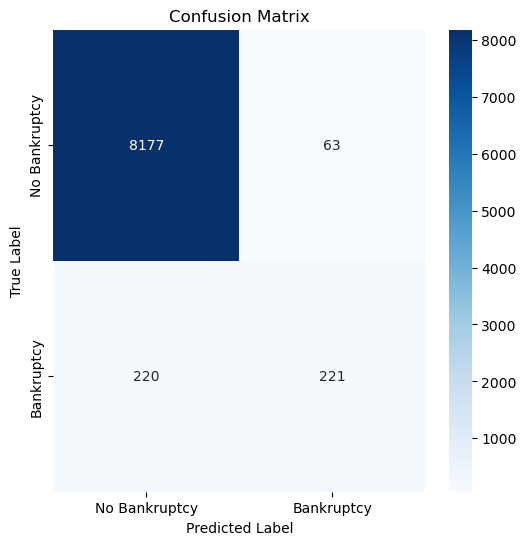

Log Loss: 0.0852


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities for ROC and PR curves
y_pred_prob = lstm_model.predict(X_test_reduced).flatten()

# Binary classification threshold
y_pred_class = (y_pred_prob > 0.5).astype(int)

# 1. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Bankruptcy', 'Bankruptcy'], yticklabels=['No Bankruptcy', 'Bankruptcy'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



# 5. Log Loss (if applicable for comparison)
logloss = log_loss(y_test, y_pred_prob)
print(f"Log Loss: {logloss:.4f}")






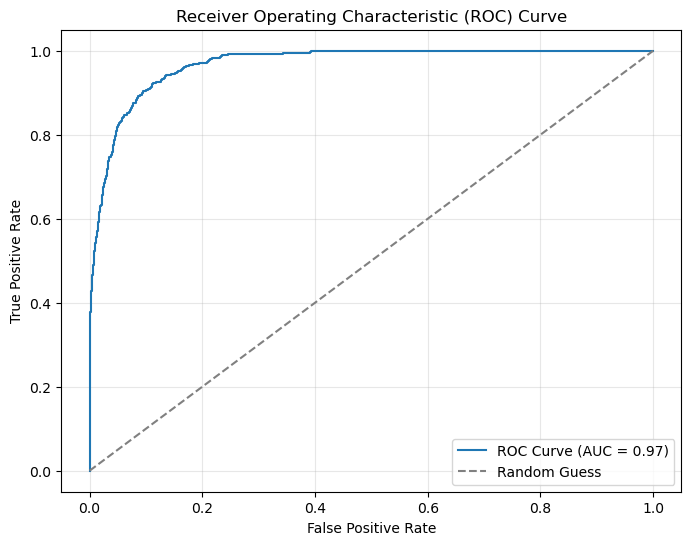

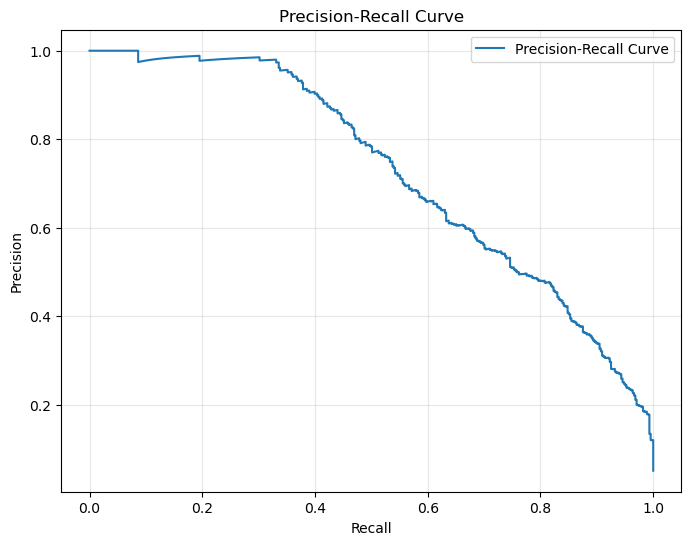

In [12]:
# 3. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4. Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

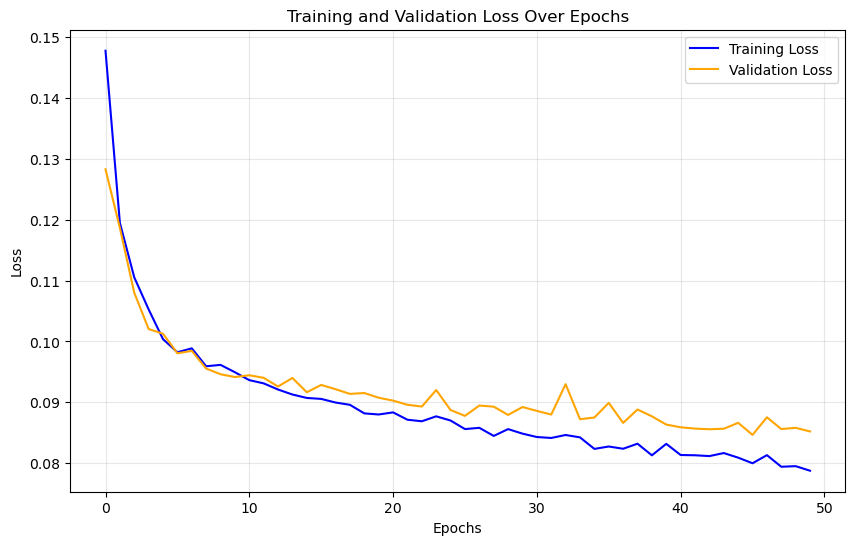

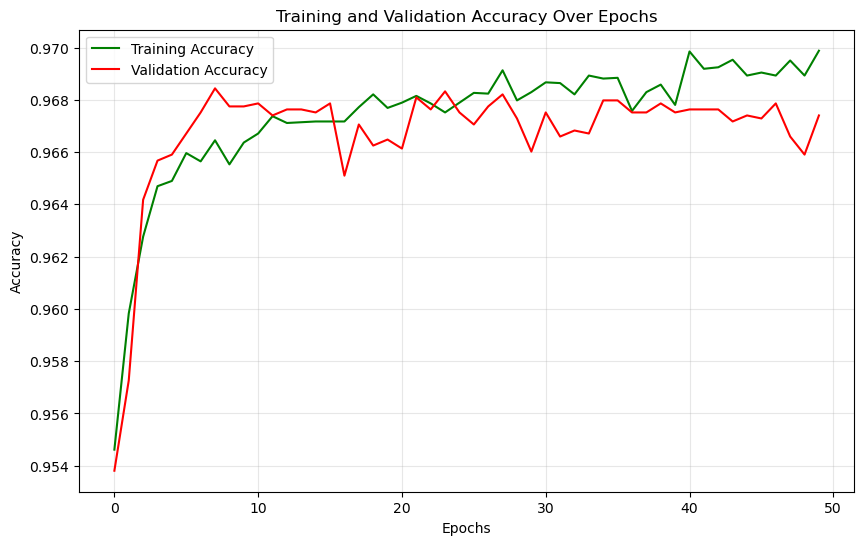

In [15]:
# 6. Visualize Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
# 7. Visualize Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title("Training and Validation Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

# Load the cleaned dataset
df = pd.read_csv('Cleaned_Bankruptcy_Data.csv')

# Separate features (X) and target (y)
X = df.iloc[:, :-1].values  # All columns except the last one
y = df.iloc[:, -1].values  # The 'class' column (binary 0/1)

# Step 1: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 2: Build the Autoencoder for Dimensionality Reduction
def build_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    encoded = Dropout(0.2)(encoded)
    
    # Decoder
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    # Autoencoder Model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)  # Encoder part for feature extraction
    
    # Compile the autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return autoencoder, encoder

# Define input dimensions and encoding dimension for the Autoencoder
input_dim = X_train.shape[1]  # Number of features
encoding_dim = 32  # Adjust this number for different levels of dimensionality reduction

# Build and train the Autoencoder
autoencoder, encoder = build_autoencoder(input_dim, encoding_dim)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Step 3: Use the encoder to extract reduced features
X_train_reduced = encoder.predict(X_train)
X_test_reduced = encoder.predict(X_test)

# Step 4: Train XGBoost on the reduced feature set
# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Train the XGBoost model
xgb_model.fit(X_train_reduced, y_train)

# Step 5: Evaluate the model
y_pred = xgb_model.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print(classification_report(y_test, y_pred))

# Save the XGBoost model
xgb_model.save_model('xgboost_autoencoder_bankruptcy_model.json')


Epoch 1/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4411 - val_loss: 1.1022
Epoch 2/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1585 - val_loss: 1.0984
Epoch 3/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7797 - val_loss: 1.0948
Epoch 4/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6272 - val_loss: 1.0935
Epoch 5/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8448 - val_loss: 1.0932
Epoch 6/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4039 - val_loss: 1.0929
Epoch 7/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9423 - val_loss: 1.0912
Epoch 8/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0009 - val_loss: 1.0903
Epoch 9/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3605 - val_loss: 1.0901
Epoch 10/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1463 - val_loss: 1.0904
Epoch 11/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2271 - val_loss: 1.0895
Epoch 12/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

C:\Users\Vikrant Mishra\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [00:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 96.69%
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8240
           1       0.75      0.53      0.62       441

    accuracy                           0.97      8681
   macro avg       0.86      0.76      0.80      8681
weighted avg       0.96      0.97      0.96      8681



C:\Users\Vikrant Mishra\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [00:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


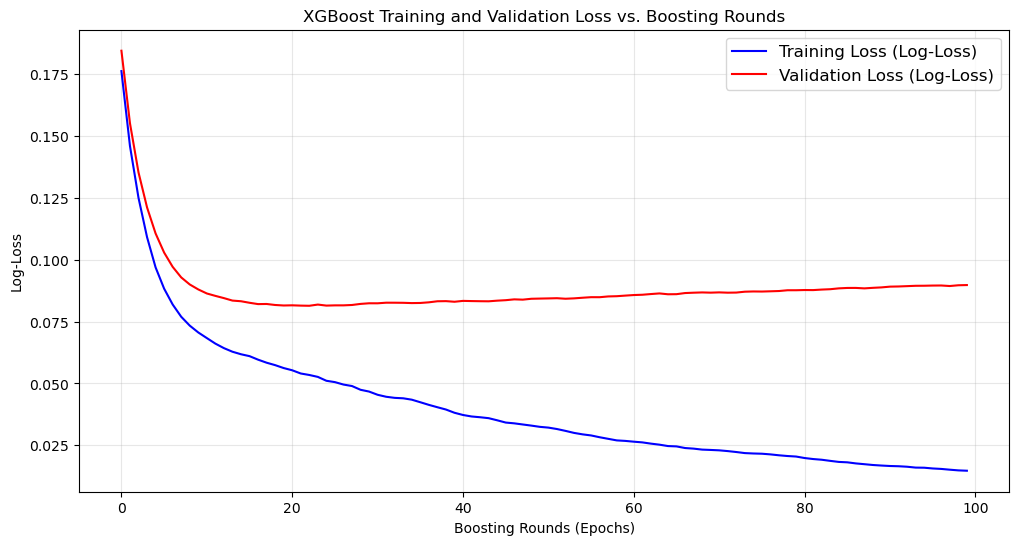

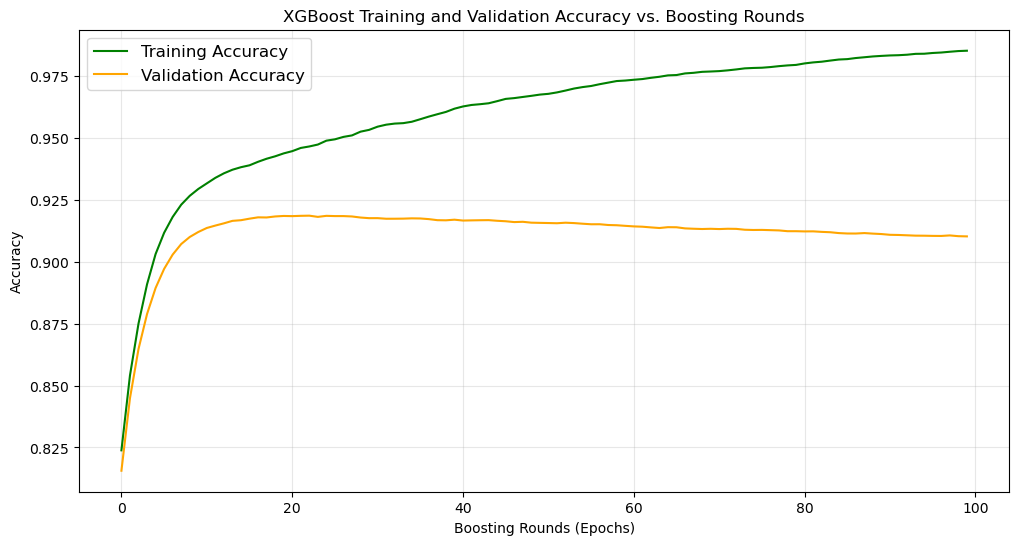

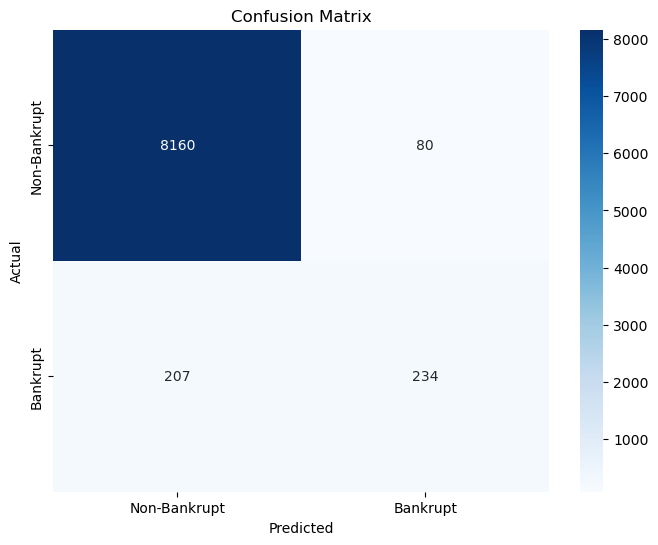

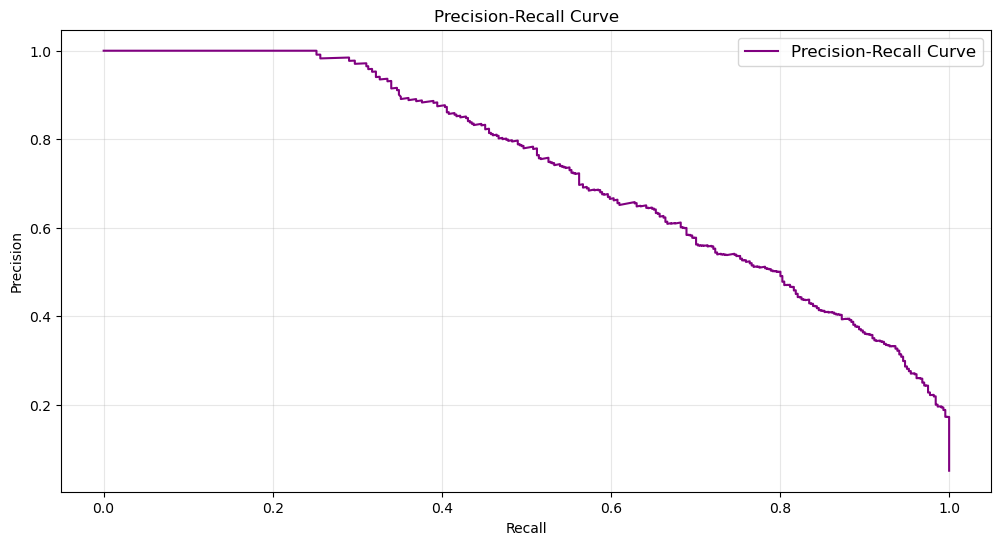

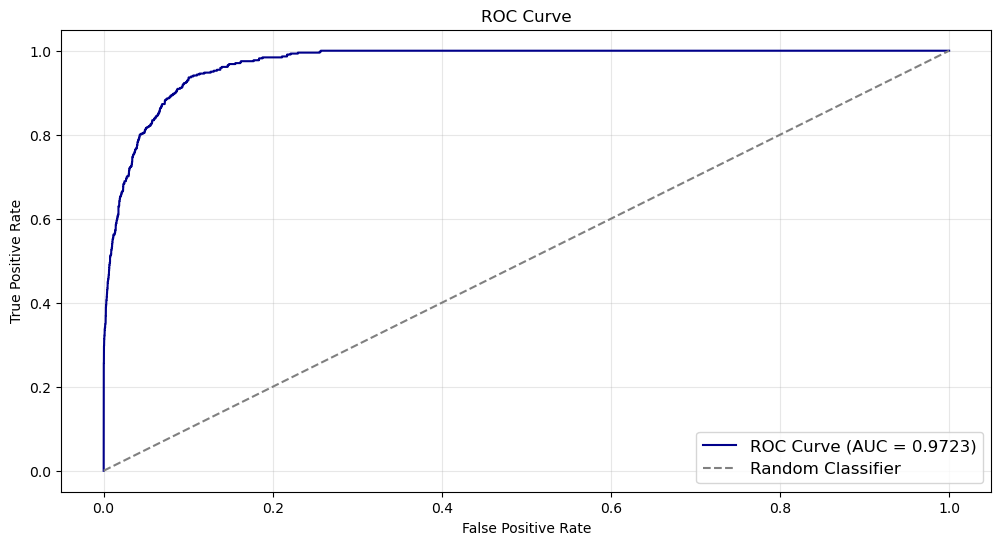

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8240
           1       0.75      0.53      0.62       441

    accuracy                           0.97      8681
   macro avg       0.86      0.76      0.80      8681
weighted avg       0.96      0.97      0.96      8681



In [19]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Train the XGBoost model with evaluation tracking
eval_set = [(X_train_reduced, y_train), (X_test_reduced, y_test)]
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train_reduced, y_train, eval_set=eval_set, verbose=False)

# Extract evaluation results (log-loss)
eval_results = xgb_model.evals_result()

# Step 2: Plot Loss vs. Boosting Rounds
plt.figure(figsize=(12, 6))
plt.plot(eval_results['validation_0']['logloss'], label='Training Loss (Log-Loss)', color='blue')
plt.plot(eval_results['validation_1']['logloss'], label='Validation Loss (Log-Loss)', color='red')
plt.xlabel('Boosting Rounds (Epochs)')
plt.ylabel('Log-Loss')
plt.title('XGBoost Training and Validation Loss vs. Boosting Rounds')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Step 3: Plot Accuracy (1 - Log-Loss) vs. Boosting Rounds
train_accuracy = 1 - np.array(eval_results['validation_0']['logloss'])
val_accuracy = 1 - np.array(eval_results['validation_1']['logloss'])

plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy', color='green')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Boosting Rounds (Epochs)')
plt.ylabel('Accuracy')
plt.title('XGBoost Training and Validation Accuracy vs. Boosting Rounds')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Step 4: Confusion Matrix
y_pred_class = xgb_model.predict(X_test_reduced)
conf_matrix = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 5: Precision-Recall Curve
y_pred_prob = xgb_model.predict_proba(X_test_reduced)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(12, 6))
plt.plot(recall, precision, label='Precision-Recall Curve', color='purple')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

# Step 6: ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Step 7: Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_class))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

# Step 1: Load the cleaned dataset
df = pd.read_csv('Cleaned_Bankruptcy_Data.csv')

# Separate features (X) and target (y)
X = df.iloc[:, :-1].values  # All columns except the last one
y = df.iloc[:, -1].values  # The 'class' column (binary 0/1)

# Step 2: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 4: Normalize the data (Standardization)
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Step 5: Build and train the Autoencoder
def build_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    encoded = Dropout(0.2)(encoded)
    
    # Decoder
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    # Autoencoder Model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)  # Encoder part for feature extraction
    
    # Compile the autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return autoencoder, encoder

# Define input dimensions and encoding dimension for the Autoencoder
input_dim = X_train_resampled.shape[1]  # Number of features
encoding_dim = 32  # Adjust this number for different levels of dimensionality reduction

# Build and train the Autoencoder
autoencoder, encoder = build_autoencoder(input_dim, encoding_dim)
autoencoder.fit(X_train_resampled, X_train_resampled, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Step 6: Use the encoder to extract reduced features
X_train_reduced = encoder.predict(X_train_resampled)
X_test_reduced = encoder.predict(X_test)

# Step 7: Hyperparameter tuning for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Step 8: Fit GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit grid search on the reduced training data
grid_search.fit(X_train_reduced, y_train_resampled)

# Display the best parameters found
print(f"Best parameters found: {grid_search.best_params_}")

# Step 9: Train XGBoost with the best parameters
best_xgb_model = grid_search.best_estimator_

# Step 10: Evaluate the model
y_pred = best_xgb_model.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print(classification_report(y_test, y_pred))

# Save the best XGBoost model
best_xgb_model.save_model('best_xgboost_autoencoder_smote_bankruptcy_model.json')


Epoch 1/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.2379 - val_loss: 0.5212
Epoch 2/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9392 - val_loss: 0.5181
Epoch 3/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2408 - val_loss: 0.5170
Epoch 4/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0200 - val_loss: 0.5165
Epoch 5/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9815 - val_loss: 0.5162
Epoch 6/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.2471 - val_loss: 0.5155
Epoch 7/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1600 - val_loss: 0.5147
Epoch 8/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0068 - val_loss: 0.5141
Epoch 9/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3343 - val_loss: 0.5139
Epoch 10/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9800 - val_loss: 0.5138
Epoch 11/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1284 - val_loss: 0.5136
Epoch 12/50
1653/1653 ━━━━━━━━

In [7]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Predictions and Probabilities for Test Set
y_pred_prob = best_xgb_model.predict_proba(X_test_reduced)[:, 1]
y_pred_class = best_xgb_model.predict(X_test_reduced)

# Step 2: Plot Loss vs. Boosting Rounds (from GridSearchCV best model)
eval_results = best_xgb_model.evals_result()

plt.figure(figsize=(12, 6))
plt.plot(eval_results['validation_0']['logloss'], label='Training Loss (Log-Loss)', color='blue')
if 'validation_1' in eval_results:  # Check if validation loss exists
    plt.plot(eval_results['validation_1']['logloss'], label='Validation Loss (Log-Loss)', color='red')
plt.xlabel('Boosting Rounds (Epochs)')
plt.ylabel('Log-Loss')
plt.title('XGBoost Training and Validation Loss vs. Boosting Rounds')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Step 3: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 4: Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(12, 6))
plt.plot(recall, precision, label='Precision-Recall Curve', color='purple')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

# Step 5: ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Step 6: Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_class))


XGBoostError: No evaluation result, `eval_set` is not used during training.

In [4]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LeakyReLU, Add, Softmax
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Step 1: Load and preprocess the data (Assumes 'Cleaned_Bankruptcy_Data.csv' is available)
df = pd.read_csv('Cleaned_Bankruptcy_Data.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Step 2: Split data and apply SMOTE for class balancing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Step 4: Build and train the Stacked Autoencoder (SAE)
def build_sae(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(256, activation='relu')(input_layer)
    encoded = Dropout(0.3)(encoded)
    encoded = Dense(128, activation='relu')(encoded)
    encoded = Dropout(0.3)(encoded)
    encoded = Dense(64, activation='relu')(encoded)

    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dropout(0.3)(decoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    autoencoder.compile(optimizer=Nadam(learning_rate=0.001), loss='mean_squared_error')
    return autoencoder, encoder

input_dim = X_train_resampled.shape[1]
autoencoder, encoder = build_sae(input_dim)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
autoencoder.fit(X_train_resampled, X_train_resampled, epochs=100, batch_size=64, shuffle=True, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Step 5: Extract reduced features
X_train_reduced = encoder.predict(X_train_resampled)
X_test_reduced = encoder.predict(X_test)

# Step 6: Train XGBoost with RandomizedSearchCV
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1],
    'scale_pos_weight': [1, 2]
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_reduced, y_train_resampled)
best_xgb_model = random_search.best_estimator_

# Step 7: Get XGBoost predictions for ANN input
X_train_xgb_output = best_xgb_model.predict_proba(X_train_reduced)
X_test_xgb_output = best_xgb_model.predict_proba(X_test_reduced)

# Step 8: Train the enhanced ANN
def build_meta_ann(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    
    # Residual block with attention
    x_res = Dense(128)(x)
    x_res = BatchNormalization()(x_res)
    x_res = LeakyReLU(alpha=0.1)(x_res)
    
    x = Add()([x, x_res])
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_dim_meta = X_train_xgb_output.shape[1]
meta_model = build_meta_ann(input_dim_meta)
meta_model.fit(X_train_xgb_output, y_train_resampled, epochs=100, batch_size=64, validation_split=0.2, shuffle=True, callbacks=[early_stopping, reduce_lr])

# Step 9: Evaluate the model
y_pred_meta = meta_model.predict(X_test_xgb_output)
y_pred_meta = (y_pred_meta > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_meta)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred_meta))

# Save the final model
meta_model.save('optimized_ann_meta_model.h5')


Epoch 1/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.1641 - val_loss: 0.5296 - learning_rate: 0.0010
Epoch 2/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.2482 - val_loss: 0.5293 - learning_rate: 0.0010
Epoch 3/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9276 - val_loss: 0.5234 - learning_rate: 0.0010
Epoch 4/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9522 - val_loss: 0.5232 - learning_rate: 0.0010
Epoch 5/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0659 - val_loss: 0.5230 - learning_rate: 0.0010
Epoch 6/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1298 - val_loss: 0.5230 - learning_rate: 0.0010
Epoch 7/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8102 - val_loss: 0.5224 - learning_rate: 0.0010
Epoch 8/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9796 - val_loss: 0.5224 - learning_rate: 0.0010
Epoch 9/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0234 - val_loss: 0.5223 - learning_rate: 0.0010
E

C:\Users\Vikrant Mishra\anaconda3\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


827/827 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9701 - loss: 0.0839 - val_accuracy: 0.9758 - val_loss: 0.0583 - learning_rate: 0.0010
Epoch 2/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9816 - loss: 0.0518 - val_accuracy: 0.9758 - val_loss: 0.0540 - learning_rate: 0.0010
Epoch 3/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9811 - loss: 0.0516 - val_accuracy: 0.9769 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 4/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9825 - loss: 0.0490 - val_accuracy: 0.9788 - val_loss: 0.0522 - learning_rate: 0.0010
Epoch 5/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9830 - loss: 0.0490 - val_accuracy: 0.9769 - val_loss: 0.0550 - learning_rate: 0.0010
Epoch 6/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9825 - loss: 0.0509 - val_accuracy: 0.9791 - val_loss: 0.0493 - learning_rate: 0.0010
Epoch 7/100
827/827 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9826 - loss: 0.0505 - val_a

Test Accuracy: 93.38%
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      8263
           1       0.40      0.77      0.53       418

    accuracy                           0.93      8681
   macro avg       0.70      0.86      0.75      8681
weighted avg       0.96      0.93      0.94      8681



272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


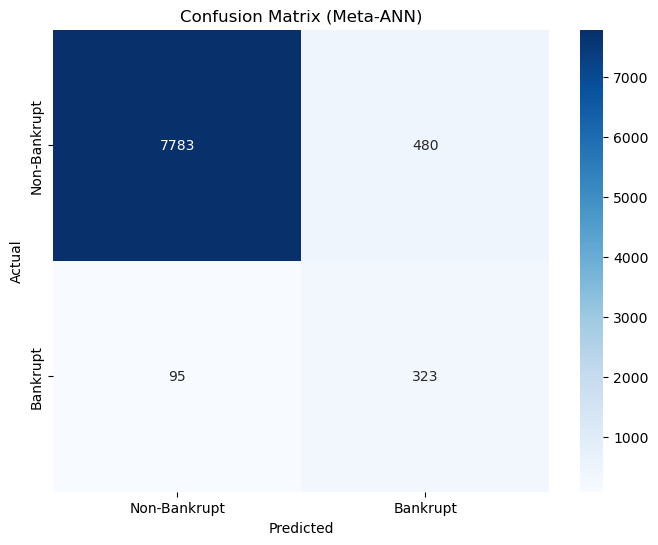

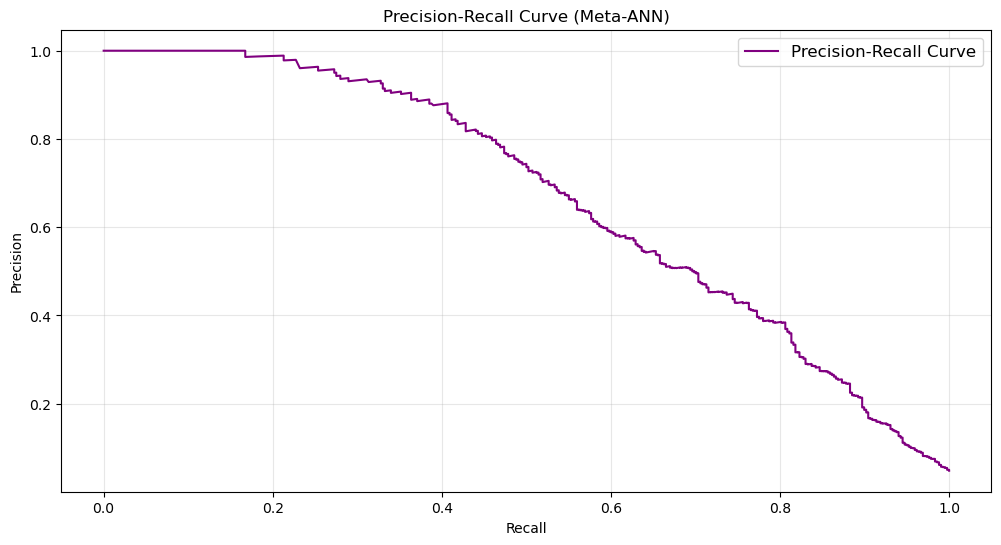

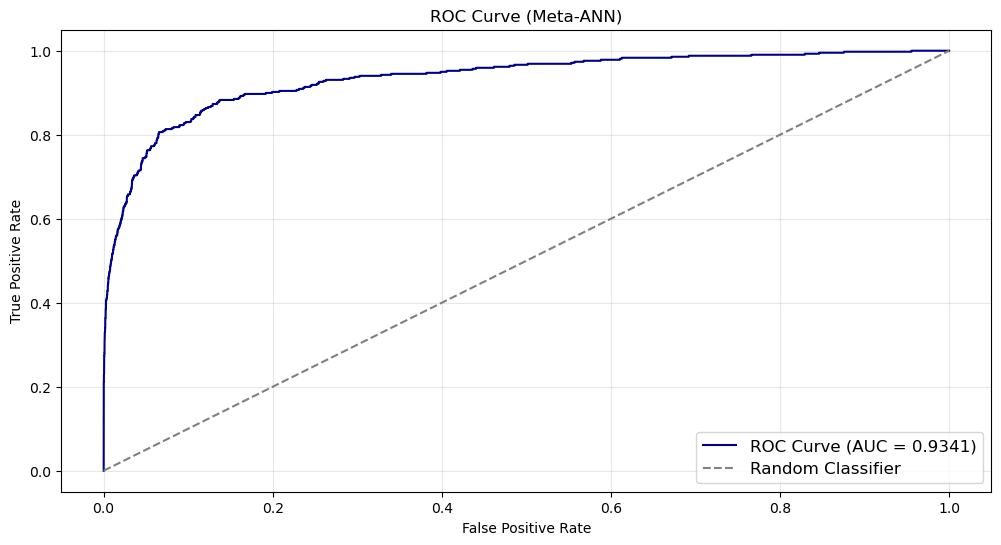

KeyError: 'loss'

<Figure size 1200x600 with 0 Axes>

In [5]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Predictions and Probabilities
y_pred_prob_meta = meta_model.predict(X_test_xgb_output).flatten()  # Predicted probabilities
y_pred_class_meta = (y_pred_prob_meta > 0.5).astype(int)  # Predicted classes

# Step 2: Confusion Matrix
conf_matrix_meta = confusion_matrix(y_test, y_pred_class_meta)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_meta, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix (Meta-ANN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 3: Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_meta)

plt.figure(figsize=(12, 6))
plt.plot(recall, precision, label='Precision-Recall Curve', color='purple')
plt.title('Precision-Recall Curve (Meta-ANN)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

# Step 4: ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_meta)
roc_auc_meta = roc_auc_score(y_test, y_pred_prob_meta)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_meta:.4f})", color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('ROC Curve (Meta-ANN)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Step 5: Training Loss and Validation Loss for Meta-ANN
history_meta = meta_model.history.history  # Access the training history

plt.figure(figsize=(12, 6))
plt.plot(history_meta['loss'], label='Training Loss (Binary Crossentropy)', color='blue')
plt.plot(history_meta['val_loss'], label='Validation Loss (Binary Crossentropy)', color='red', linestyle='--')
plt.title('Meta-ANN Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Step 6: Accuracy for Meta-ANN
plt.figure(figsize=(12, 6))
plt.plot(history_meta['accuracy'], label='Training Accuracy', color='green')
plt.plot(history_meta['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
plt.title('Meta-ANN Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Step 7: Detailed Classification Report
print("Classification Report (Meta-ANN):")
print(classification_report(y_test, y_pred_class_meta))


Target column automatically detected: class
Feature Importance Ranking:
   Feature  Importance
0       id    0.354072
27  Attr27    0.033996
46  Attr46    0.021157
24  Attr24    0.020293
34  Attr34    0.016987
..     ...         ...
30  Attr30    0.006881
52  Attr52    0.006777
62  Attr62    0.006712
37  Attr37    0.006562
59  Attr59    0.005749

[65 rows x 2 columns]


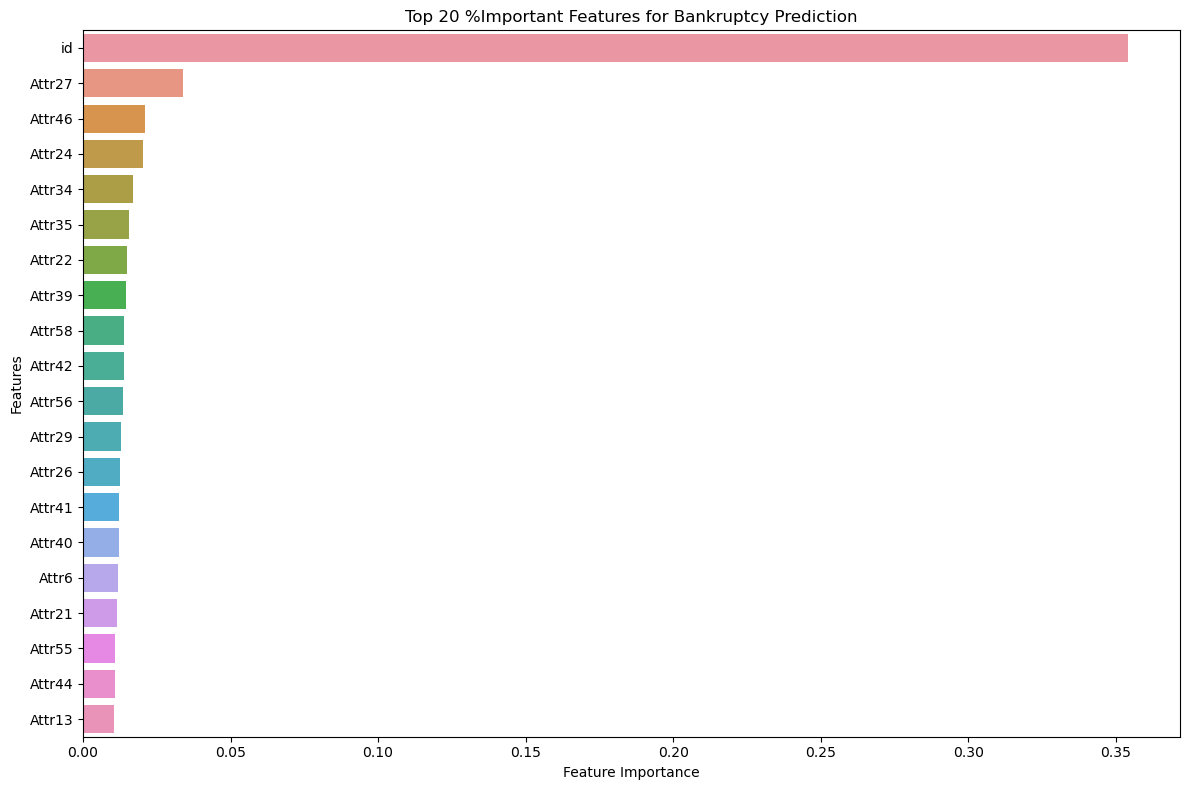

C:\Users\Vikrant Mishra\AppData\Local\Temp\ipykernel_24220\2788235576.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[target_col] = y  # Add the target column back to the new dataset



Logistic Regression Accuracy on Filtered Data: 0.95
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      8240
           1       0.97      0.07      0.12       441

    accuracy                           0.95      8681
   macro avg       0.96      0.53      0.55      8681
weighted avg       0.95      0.95      0.93      8681


Random Forest Accuracy on Filtered Data: 0.98
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8240
           1       0.92      0.69      0.79       441

    accuracy                           0.98      8681
   macro avg       0.95      0.84      0.89      8681
weighted avg       0.98      0.98      0.98      8681


XGBoost Accuracy on Filtered Data: 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8240
           1       0.89      0.80      0.84       441

    accuracy                           0.

In [15]:
    # Import necessary libraries
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import accuracy_score, classification_report
    from sklearn.preprocessing import StandardScaler

    # Load the dataset
    data = pd.read_csv('Cleaned_Bankruptcy_Data.csv')

    # Automatically find the target column by checking if any column is binary (0/1 or True/False)
    binary_columns = [col for col in data.columns if data[col].nunique() == 2]

    # If binary columns exist, set the first one as the target column
    if binary_columns:
        target_col = binary_columns[0]
        print(f"Target column automatically detected: {target_col}")
    else:
        raise ValueError("No suitable binary column found for classification.")

    # Split the data into features (X) and target (y)
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Split data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection using RandomForest for feature importance
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_scaled, y_train)

    # Get feature importance scores
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Print and save feature importance to a CSV file
    print("Feature Importance Ranking:")
    print(feature_importance_df)
    feature_importance_df.to_csv('feature_importance_ranking.csv', index=False)

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title('Top 20 %Important Features for Bankruptcy Prediction')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig('feature_importance_visualization.png')
    plt.show()

    # Filter out features with importance above a threshold (e.g., top 20 most important features)
    threshold = feature_importance_df['Importance'].quantile(0.8)
    important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].values

    # Create a new dataset with only important features
    filtered_data = data[important_features]
    filtered_data[target_col] = y  # Add the target column back to the new dataset

    # Save the filtered dataset to a new CSV file
    filtered_data.to_csv('filtered_bankruptcy_data.csv', index=False)

    # Split the filtered data for model training
    X_filtered = filtered_data.drop(columns=[target_col])
    y_filtered = filtered_data[target_col]
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

    # Standardize the filtered features
    X_train_f_scaled = scaler.fit_transform(X_train_f)
    X_test_f_scaled = scaler.transform(X_test_f)

    # Model Training and Evaluation on filtered data
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'Neural Network': MLPClassifier(random_state=42, max_iter=500)
    }

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_f_scaled, y_train_f)

        # Predict on the test set
        y_pred_f = model.predict(X_test_f_scaled)

        # Evaluate the model
        accuracy = accuracy_score(y_test_f, y_pred_f)
        print(f"\n{model_name} Accuracy on Filtered Data: {accuracy:.2f}")
        print(classification_report(y_test_f, y_pred_f))


Logistic Regression Cross-Validation Accuracy: 0.95 (+/- 0.00)
Logistic Regression ROC-AUC Score: 0.91


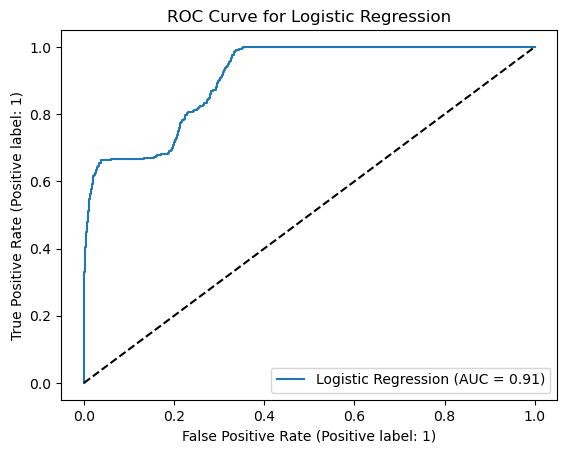

Random Forest Cross-Validation Accuracy: 0.98 (+/- 0.00)
Random Forest ROC-AUC Score: 0.99


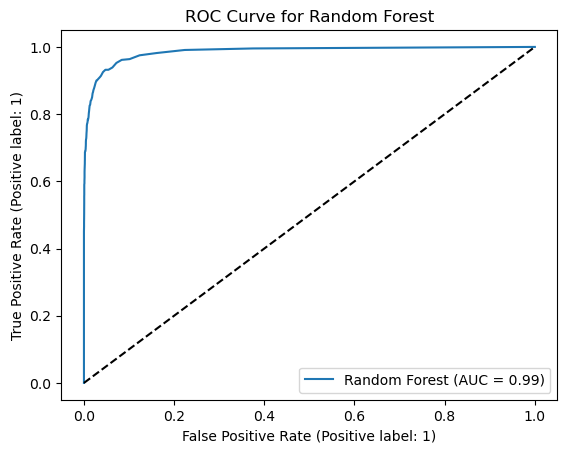

XGBoost Cross-Validation Accuracy: 0.99 (+/- 0.00)
XGBoost ROC-AUC Score: 0.99


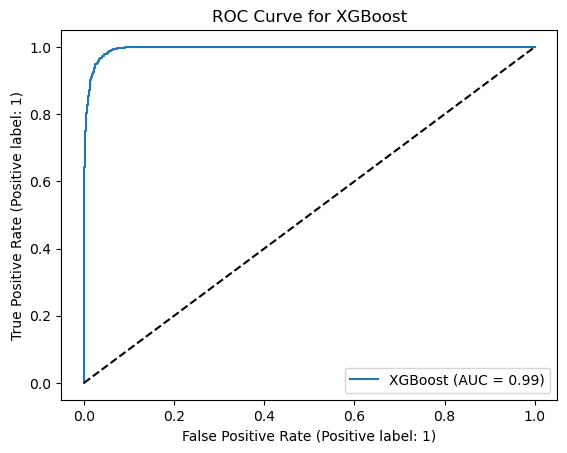

Neural Network Cross-Validation Accuracy: 0.97 (+/- 0.00)
Neural Network ROC-AUC Score: 0.97


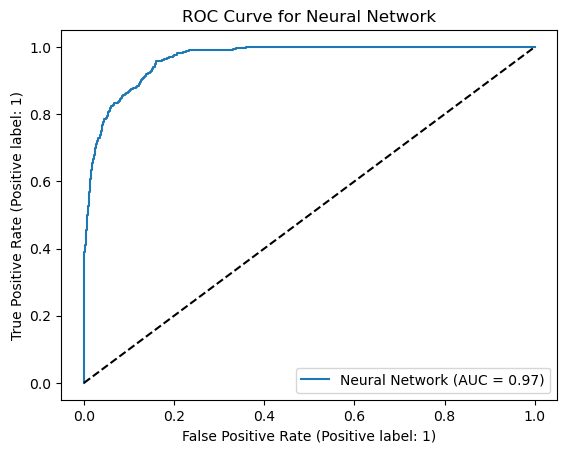

In [4]:
# Import necessary libraries
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Define a function for cross-validation and ROC-AUC computation
def validate_model(model, X, y, model_name):
    # Cross-validation setup (StratifiedKFold to maintain class distribution)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")
    
    # Train the model and calculate ROC-AUC on test data
    model.fit(X_train_f_scaled, y_train_f)
    y_pred_proba = model.predict_proba(X_test_f_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test_f, y_pred_proba)
    print(f"{model_name} ROC-AUC Score: {roc_auc:.2f}")
    
    # Plot ROC curve using RocCurveDisplay
    RocCurveDisplay.from_predictions(y_test_f, y_pred_proba, name=model_name)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.title(f'ROC Curve for {model_name}')
    plt.show()

# Validate each model
for model_name, model in models.items():
    validate_model(model, X_train_f_scaled, y_train_f, model_name)


In [9]:
    # Import necessary libraries
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from tensorflow.keras.models import Model, Sequential
    from tensorflow.keras.layers import Dense, Input
    from xgboost import XGBClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, classification_report
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import StratifiedKFold
    import numpy as np

    # Load the filtered dataset
    data = pd.read_csv('filtered_bankruptcy_data.csv')

    # Identify the target column (assume the last column is the target)
    target_col = data.columns[-1]

    # Split the data into features (X) and target (y)
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Split the data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Standardize the training and testing sets independently
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 1: Build and train the Stacked Autoencoder (SAE)
    input_dim = X_train_scaled.shape[1]
    encoding_dim = 32  # Adjust based on the number of reduced features needed

    # Build the autoencoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)  # Encoder for feature extraction

    # Compile and train the autoencoder
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

    # Transform only the training data using the trained encoder
    X_train_encoded = encoder.predict(X_train_scaled)

    # Apply SMOTE to the encoded training features
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

    # Transform the test data using the same trained encoder (no SMOTE on test data)
    X_test_encoded = encoder.predict(X_test_scaled)

    # Step 2: Build and train the Neural Network on encoded data
    nn_model = Sequential([
        Dense(64, activation='relu', input_shape=(encoding_dim,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    nn_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2)

    # Evaluate the Neural Network
    nn_predictions_test = nn_model.predict(X_test_encoded).flatten()
    print(f"Neural Network AUC: {accuracy_score(y_test, (nn_predictions_test > 0.5).astype(int)):.2f}")
    print(classification_report(y_test, (nn_predictions_test > 0.5).astype(int)))

    # Step 3: Build the Neural Network + XGBoost (Hybrid Stacking)
    # Train the XGBoost model with resampled data
    xgb_model = XGBClassifier(random_state=42)
    xgb_model.fit(X_train_resampled, y_train_resampled)

    xgb_predictions_test = xgb_model.predict_proba(X_test_encoded)[:, 1]

    # Combine predictions for meta-learner using cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    stacked_train_features = []
    stacked_train_labels = []

    for train_idx, val_idx in cv.split(X_train_resampled, y_train_resampled):
        # Split training data into training and validation sets
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        # Train models on fold data
        nn_model.fit(X_fold_train, y_fold_train, epochs=10, batch_size=32, verbose=0)
        xgb_model.fit(X_fold_train, y_fold_train)

        # Generate fold predictions
        nn_fold_preds = nn_model.predict(X_fold_val).flatten()
        xgb_fold_preds = xgb_model.predict_proba(X_fold_val)[:, 1]

        # Stack predictions
        fold_features = np.column_stack((nn_fold_preds, xgb_fold_preds))
        stacked_train_features.append(fold_features)
        stacked_train_labels.append(y_fold_val)

    # Combine fold predictions into a single training set
    stacked_train_features = np.vstack(stacked_train_features)
    stacked_train_labels = np.hstack(stacked_train_labels)

    # Train a Logistic Regression meta-learner on the stacked features
    meta_learner = LogisticRegression()
    meta_learner.fit(stacked_train_features, stacked_train_labels)

    # Test meta-learner on the actual test set
    stacked_test_features = np.column_stack((nn_predictions_test, xgb_predictions_test))
    meta_predictions_test = meta_learner.predict(stacked_test_features)

    # Evaluate the meta-learner
    print(f"Hybrid Stacking AUC: {accuracy_score(y_test, meta_predictions_test):.2f}")
    print(classification_report(y_test, meta_predictions_test))


Epoch 1/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8753 - val_loss: 1.5138
Epoch 2/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4982 - val_loss: 1.5081
Epoch 3/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6171 - val_loss: 1.5080
Epoch 4/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9572 - val_loss: 1.5072
Epoch 5/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0895 - val_loss: 1.5026
Epoch 6/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7303 - val_loss: 1.5004
Epoch 7/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8779 - val_loss: 1.4992
Epoch 8/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8605 - val_loss: 1.4961
Epoch 9/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5833 - val_loss: 1.4951
Epoch 10/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8313 - val_loss: 1.4942
Epoch 11/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7281 - val_loss: 1.4979
Epoch 12/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

C:\Users\Vikrant Mishra\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1653/1653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8243 - loss: 0.3577 - val_accuracy: 0.8012 - val_loss: 0.3592
Epoch 2/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8934 - loss: 0.2210 - val_accuracy: 0.9061 - val_loss: 0.2490
Epoch 3/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8917 - loss: 0.2200 - val_accuracy: 0.8682 - val_loss: 0.2798
Epoch 4/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.2062 - val_accuracy: 0.8578 - val_loss: 0.2933
Epoch 5/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8981 - loss: 0.2072 - val_accuracy: 0.8883 - val_loss: 0.2522
Epoch 6/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9045 - loss: 0.1968 - val_accuracy: 0.9551 - val_loss: 0.1702
Epoch 7/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9143 - loss: 0.1937 - val_accuracy: 0.9309 - val_loss: 0.2070
Epoch 8/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9259 - loss: 0.1736 - val_accurac

272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network AUC: 0.94
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      8263
           1       0.43      0.90      0.58       418

    accuracy                           0.94      8681
   macro avg       0.71      0.92      0.77      8681
weighted avg       0.97      0.94      0.95      8681

414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Hybrid Stacking AUC: 0.97
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      8263
           1       0.62      0.79      0.69       418

    accuracy                           0.97      8681
   macro avg       0.80      0.88      0.84      8681
weighted avg       0.97      0.97      0.97      8681



In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Convert the data to NumPy arrays for StratifiedKFold
X_train_np = X_train.values
y_train_np = y_train.values

# Define StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results for each fold
nn_aucs = []
xgb_aucs = []
stacking_aucs = []

for train_idx, val_idx in cv.split(X_train_np, y_train_np):
    # Split the data into training and validation sets
    X_fold_train, X_fold_val = X_train_np[train_idx], X_train_np[val_idx]
    y_fold_train, y_fold_val = y_train_np[train_idx], y_train_np[val_idx]

    # Standardize the features
    X_fold_train_scaled = scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = scaler.transform(X_fold_val)

    # Train the autoencoder on training data
    autoencoder.fit(X_fold_train_scaled, X_fold_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    
    # Transform data using the encoder
    X_fold_train_encoded = encoder.predict(X_fold_train_scaled)
    X_fold_val_encoded = encoder.predict(X_fold_val_scaled)
    
    # Apply SMOTE on the training data
    X_fold_train_resampled, y_fold_train_resampled = smote.fit_resample(X_fold_train_encoded, y_fold_train)

    # Ensure labels are properly reshaped
    y_fold_train_resampled = np.array(y_fold_train_resampled).reshape(-1, 1)
    y_fold_val = np.array(y_fold_val).reshape(-1, 1)

    # Train Neural Network
    nn_model.fit(X_fold_train_resampled, y_fold_train_resampled, epochs=50, batch_size=32, verbose=0)
    nn_val_predictions = nn_model.predict(X_fold_val_encoded).flatten()
    nn_auc = roc_auc_score(y_fold_val, nn_val_predictions)
    nn_aucs.append(nn_auc)
    
    # Train XGBoost
    xgb_model.fit(X_fold_train_resampled, y_fold_train_resampled.ravel())
    xgb_val_predictions = xgb_model.predict_proba(X_fold_val_encoded)[:, 1]
    xgb_auc = roc_auc_score(y_fold_val, xgb_val_predictions)
    xgb_aucs.append(xgb_auc)
    
    # Combine predictions for meta-learner
    stacked_features = np.column_stack((nn_val_predictions, xgb_val_predictions))
    
    # Train Logistic Regression meta-learner
    meta_learner.fit(stacked_features, y_fold_val.ravel())
    stacked_val_predictions = meta_learner.predict_proba(stacked_features)[:, 1]
    stacking_auc = roc_auc_score(y_fold_val, stacked_val_predictions)
    stacking_aucs.append(stacking_auc)

# Report validation results
print(f"Neural Network AUC (Mean ± Std): {np.mean(nn_aucs):.4f} ± {np.std(nn_aucs):.4f}")
print(f"XGBoost AUC (Mean ± Std): {np.mean(xgb_aucs):.4f} ± {np.std(xgb_aucs):.4f}")
print(f"Hybrid Stacking AUC (Mean ± Std): {np.mean(stacking_aucs):.4f} ± {np.std(stacking_aucs):.4f}")


869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network AUC (Mean ± Std): 0.9807 ± 0.0027
XGBoost AUC (Mean ± Std): 0.9812 ± 0.0013
Hybrid Stacking AUC (Mean ± Std): 0.9848 ± 0.0006


In [2]:
# Import necessary libraries for evaluation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Loading and Preprocessing
data = pd.read_csv('filtered_bankruptcy_data.csv')
target_col = data.columns[-1]
X = data.drop(columns=[target_col])
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Build and Train Autoencoder for Feature Reduction
input_dim = X_train_scaled.shape[1]
encoding_dim = 32
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Step 3: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# Step 4: Train Base Models
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(encoding_dim,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2)

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predictions
nn_predictions_test = nn_model.predict(X_test_encoded).flatten()
xgb_predictions_test = xgb_model.predict_proba(X_test_encoded)[:, 1]

stacked_test_features = np.column_stack((nn_predictions_test, xgb_predictions_test))
meta_learner = LogisticRegression()
meta_learner.fit(stacked_test_features, y_test)
meta_predictions_test = meta_learner.predict(stacked_test_features)

# Step 5: Evaluation Plots
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, meta_predictions_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Precision-Recall Curve
meta_y_pred_prob = meta_learner.predict_proba(stacked_test_features)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, meta_y_pred_prob)
plt.figure(figsize=(12, 6))
plt.plot(recall, precision, label='Precision-Recall Curve', color='purple')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, meta_y_pred_prob)
roc_auc = roc_auc_score(y_test, meta_y_pred_prob)
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, meta_predictions_test))


Epoch 1/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6784 - val_loss: 1.5080
Epoch 2/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4645 - val_loss: 1.5043
Epoch 3/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7022 - val_loss: 1.5034
Epoch 4/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8150 - val_loss: 1.5000
Epoch 5/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2668 - val_loss: 1.4998
Epoch 6/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7904 - val_loss: 1.4996
Epoch 7/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8009 - val_loss: 1.4994
Epoch 8/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5570 - val_loss: 1.4993
Epoch 9/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9143 - val_loss: 1.4986
Epoch 10/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7320 - val_loss: 1.4985
Epoch 11/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0108 - val_loss: 1.4983
Epoch 12/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

KeyboardInterrupt: 

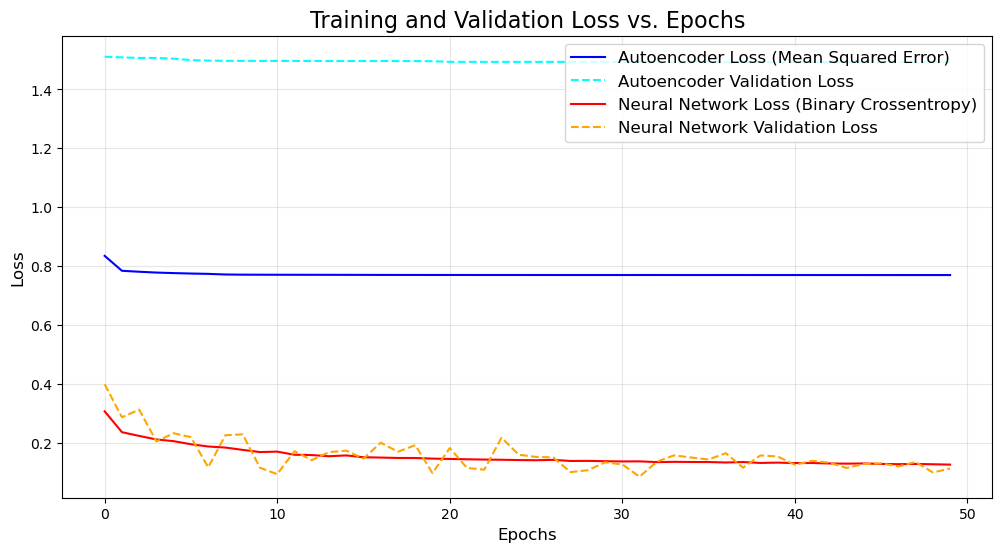

In [4]:

# Step 4: Plotting Loss Curves
def plot_loss_curves(autoencoder_history, nn_history):
    plt.figure(figsize=(12, 6))
    
    # Plot loss for autoencoder
    plt.plot(autoencoder_history.history['loss'], label='Autoencoder Loss (Mean Squared Error)', color='blue')
    plt.plot(autoencoder_history.history['val_loss'], label='Autoencoder Validation Loss', color='cyan', linestyle='--')
    
    # Plot loss for neural network
    plt.plot(nn_history.history['loss'], label='Neural Network Loss (Binary Crossentropy)', color='red')
    plt.plot(nn_history.history['val_loss'], label='Neural Network Validation Loss', color='orange', linestyle='--')
    
    # Add titles and labels
    plt.title('Training and Validation Loss vs. Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Plot the loss curves
plot_loss_curves(autoencoder_history, nn_history)


[0]	validation_0-logloss:0.49738	validation_1-logloss:0.50178
[1]	validation_0-logloss:0.38473	validation_1-logloss:0.39467
[2]	validation_0-logloss:0.31058	validation_1-logloss:0.32463
[3]	validation_0-logloss:0.26180	validation_1-logloss:0.27914
[4]	validation_0-logloss:0.22864	validation_1-logloss:0.24923
[5]	validation_0-logloss:0.20346	validation_1-logloss:0.22817
[6]	validation_0-logloss:0.18633	validation_1-logloss:0.21407
[7]	validation_0-logloss:0.17328	validation_1-logloss:0.20207
[8]	validation_0-logloss:0.16282	validation_1-logloss:0.19200
[9]	validation_0-logloss:0.15548	validation_1-logloss:0.18524
[10]	validation_0-logloss:0.14598	validation_1-logloss:0.17768
[11]	validation_0-logloss:0.14090	validation_1-logloss:0.17333
[12]	validation_0-logloss:0.13641	validation_1-logloss:0.16930
[13]	validation_0-logloss:0.13057	validation_1-logloss:0.16469
[14]	validation_0-logloss:0.12666	validation_1-logloss:0.16185
[15]	validation_0-logloss:0.12437	validation_1-logloss:0.16025
[1

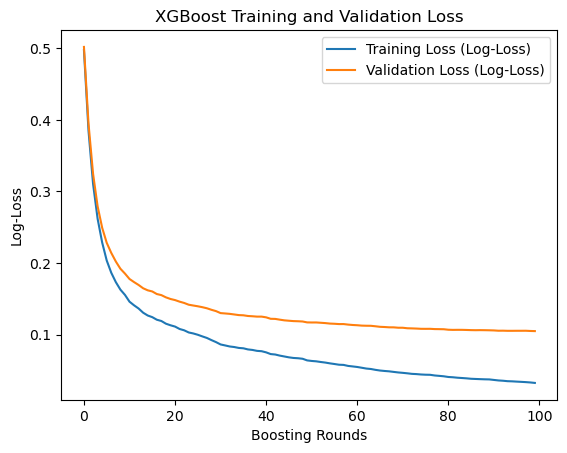

In [5]:
# Train the XGBoost model with evaluation tracking
eval_set = [(X_train_resampled, y_train_resampled), (X_test_encoded, y_test)]
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled, eval_set=eval_set, verbose=True)

# Extract evaluation results
eval_results = xgb_model.evals_result()

# Plot training and validation log-loss
import matplotlib.pyplot as plt

plt.plot(eval_results['validation_0']['logloss'], label='Training Loss (Log-Loss)')
plt.plot(eval_results['validation_1']['logloss'], label='Validation Loss (Log-Loss)')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log-Loss')
plt.title('XGBoost Training and Validation Loss')
plt.legend()
plt.show()


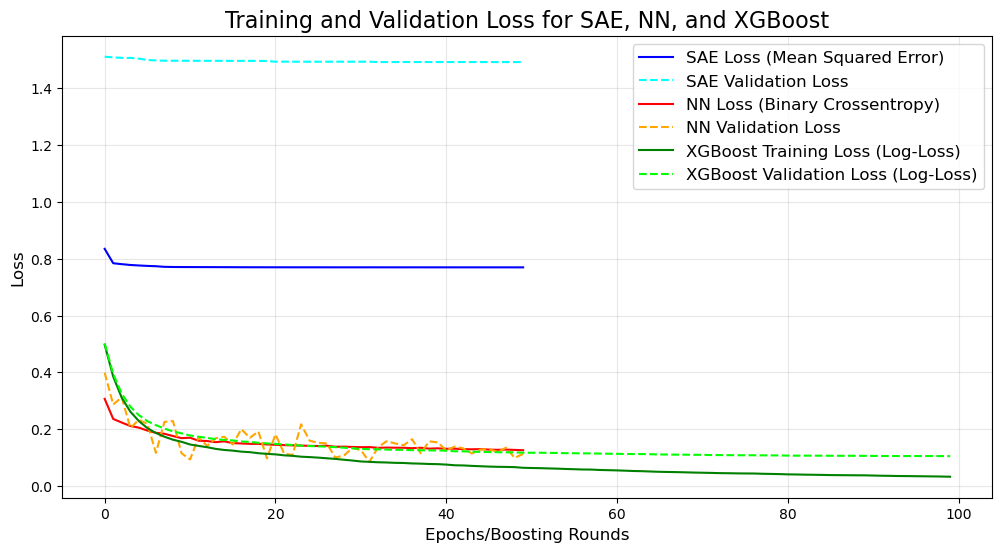

<Figure size 640x480 with 0 Axes>

In [8]:
# Step 4: Plotting Combined Loss Curves
def plot_combined_loss_curves(autoencoder_history, nn_history, xgb_eval_results):
    plt.figure(figsize=(12, 6))
    
    # Plot loss for SAE
    plt.plot(autoencoder_history.history['loss'], label='SAE Loss (Mean Squared Error)', color='blue', linestyle='-')
    plt.plot(autoencoder_history.history['val_loss'], label='SAE Validation Loss', color='cyan', linestyle='--')
    
    # Plot loss for Neural Network
    plt.plot(nn_history.history['loss'], label='NN Loss (Binary Crossentropy)', color='red', linestyle='-')
    plt.plot(nn_history.history['val_loss'], label='NN Validation Loss', color='orange', linestyle='--')
    
    # Plot XGBoost loss
    plt.plot(xgb_eval_results['validation_0']['logloss'], label='XGBoost Training Loss (Log-Loss)', color='green', linestyle='-')
    plt.plot(xgb_eval_results['validation_1']['logloss'], label='XGBoost Validation Loss (Log-Loss)', color='lime', linestyle='--')
    
    # Add titles and labels
    plt.title('Training and Validation Loss for SAE, NN, and XGBoost', fontsize=16)
    plt.xlabel('Epochs/Boosting Rounds', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Plot the combined loss curves
plot_combined_loss_curves(autoencoder_history, nn_history, eval_results)
plt.savefig('combined_loss_curves.png', dpi=300)



In [1]:
#SAE after smote
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Load the filtered dataset
data = pd.read_csv('filtered_bankruptcy_data.csv')

# Identify the target column (assume the last column is the target)
target_col = data.columns[-1]

# Split the data into features (X) and target (y)
X = data.drop(columns=[target_col])
y = data[target_col]

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the training and testing sets independently
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 1: Apply SMOTE to the scaled training data (before SAE)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 2: Build and train the Stacked Autoencoder (SAE) on resampled data
input_dim = X_train_resampled.shape[1]
encoding_dim = 32  # Adjust based on the number of reduced features needed

# Build the autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)  # Encoder for feature extraction

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_train_resampled, X_train_resampled, epochs=50, batch_size=32, validation_split=0.2)

# Transform the data using the trained encoder
X_train_encoded = encoder.predict(X_train_resampled)
X_test_encoded = encoder.predict(X_test_scaled)

# Step 3: Build and train the Neural Network on encoded data
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(encoding_dim,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_encoded, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the Neural Network
nn_predictions_test = nn_model.predict(X_test_encoded).flatten()
print(f"Neural Network AUC: {accuracy_score(y_test, (nn_predictions_test > 0.5).astype(int)):.2f}")
print(classification_report(y_test, (nn_predictions_test > 0.5).astype(int)))

# Step 4: Train the XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_encoded, y_train_resampled)

xgb_predictions_test = xgb_model.predict_proba(X_test_encoded)[:, 1]

# Step 5: Hybrid Stacking with Meta-Learner
# Combine predictions for meta-learner using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stacked_train_features = []
stacked_train_labels = []

for train_idx, val_idx in cv.split(X_train_encoded, y_train_resampled):
    # Split training data into training and validation sets
    X_fold_train, X_fold_val = X_train_encoded[train_idx], X_train_encoded[val_idx]
    y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]
    
    # Train models on fold data
    nn_model.fit(X_fold_train, y_fold_train, epochs=10, batch_size=32, verbose=0)
    xgb_model.fit(X_fold_train, y_fold_train)
    
    # Generate fold predictions
    nn_fold_preds = nn_model.predict(X_fold_val).flatten()
    xgb_fold_preds = xgb_model.predict_proba(X_fold_val)[:, 1]
    
    # Stack predictions
    fold_features = np.column_stack((nn_fold_preds, xgb_fold_preds))
    stacked_train_features.append(fold_features)
    stacked_train_labels.append(y_fold_val)

# Combine fold predictions into a single training set
stacked_train_features = np.vstack(stacked_train_features)
stacked_train_labels = np.hstack(stacked_train_labels)

# Train a Logistic Regression meta-learner on the stacked features
meta_learner = LogisticRegression()
meta_learner.fit(stacked_train_features, stacked_train_labels)

# Test meta-learner on the actual test set
stacked_test_features = np.column_stack((nn_predictions_test, xgb_predictions_test))
meta_predictions_test = meta_learner.predict(stacked_test_features)

# Evaluate the meta-learner
print(f"Hybrid Stacking AUC: {accuracy_score(y_test, meta_predictions_test):.2f}")
print(classification_report(y_test, meta_predictions_test))


Epoch 1/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.2322 - val_loss: 0.8509
Epoch 2/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2981 - val_loss: 0.8498
Epoch 3/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0986 - val_loss: 0.8495
Epoch 4/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5655 - val_loss: 0.8493
Epoch 5/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0411 - val_loss: 0.8491
Epoch 6/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4916 - val_loss: 0.8490
Epoch 7/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0747 - val_loss: 0.8489
Epoch 8/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3871 - val_loss: 0.8488
Epoch 9/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1085 - val_loss: 0.8487
Epoch 10/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1297 - val_loss: 0.8487
Epoch 11/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1536 - val_loss: 0.8487
Epoch 12/50
1653/1653 ━━━━━━━━

C:\Users\Vikrant Mishra\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1653/1653 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8509 - loss: 0.3098 - val_accuracy: 0.8812 - val_loss: 0.2941
Epoch 2/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8912 - loss: 0.2271 - val_accuracy: 0.9561 - val_loss: 0.1782
Epoch 3/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8973 - loss: 0.2171 - val_accuracy: 0.9035 - val_loss: 0.2302
Epoch 4/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8981 - loss: 0.2194 - val_accuracy: 0.9030 - val_loss: 0.2298
Epoch 5/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9007 - loss: 0.2086 - val_accuracy: 0.9045 - val_loss: 0.2437
Epoch 6/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9024 - loss: 0.2032 - val_accuracy: 0.9014 - val_loss: 0.2227
Epoch 7/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9108 - loss: 0.1930 - val_accuracy: 0.8906 - val_loss: 0.2586
Epoch 8/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9144 - loss: 0.1889 - val_accurac

272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network AUC: 0.95
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8263
           1       0.50      0.88      0.64       418

    accuracy                           0.95      8681
   macro avg       0.75      0.92      0.81      8681
weighted avg       0.97      0.95      0.96      8681

414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Hybrid Stacking AUC: 0.97
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8263
           1       0.62      0.80      0.70       418

    accuracy                           0.97      8681
   macro avg       0.80      0.89      0.84      8681
weighted avg       0.97      0.97      0.97      8681

